In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load dataset

In [2]:

df = pd.read_csv("D:\\Test\\processed_dataset.csv")

# Combine year, month, and day to create a datetime column

In [3]:

df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])

# Fill missing values

In [4]:

df.ffill(inplace=True)

# Handle NaNs in prev_day_demand

In [5]:

df["prev_day_demand"].fillna(df["prev_day_demand"].mean(), inplace=True)

C:\Users\Vandh\AppData\Local\Temp\ipykernel_19888\647230377.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["prev_day_demand"].fillna(df["prev_day_demand"].mean(), inplace=True)


# OneHotEncode categorical features

In [6]:

ohe_Encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas')

In [7]:
categorical_cols = ['rainfall_category', 'solar_category', 'season', 'day_of_week']
encoded_df = ohe_Encoder.fit_transform(df[categorical_cols])

In [8]:
# Concatenate encoded features and drop originals
df = pd.concat([df, encoded_df], axis=1).drop(columns=categorical_cols)

In [9]:

df = df.rename(columns={"demand": "y"})

In [10]:
# features for model training
features = [
    "min_temperature", "max_temperature", "solar_exposure", "RRP", 
    "is_weekend", "prev_day_demand"
] + list(encoded_df.columns)  




# Prophet Model WITHOUT Regressors

In [11]:


model_basic = Prophet()
model_basic.fit(df[["ds", "y"]])

18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Future dates
future_basic = model_basic.make_future_dataframe(periods=30)

In [13]:
# Predict
forecast_basic = model_basic.predict(future_basic)

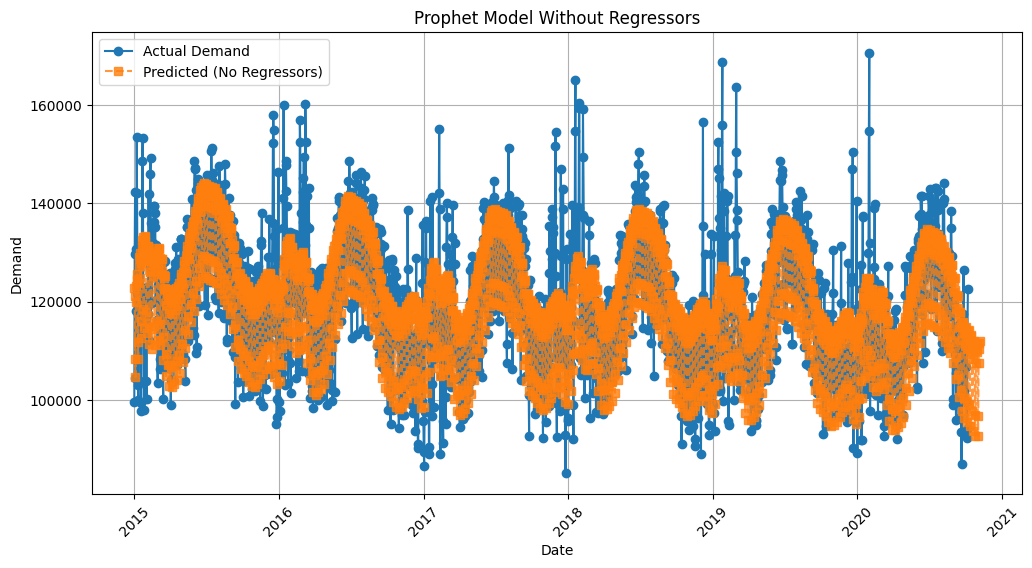

In [14]:
# Prophet model WITHOUT regressors
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast_basic["ds"], forecast_basic["yhat"], label="Predicted (No Regressors)", marker='s', linestyle="--",  alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Prophet Model Without Regressors")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [15]:

#Prophet Model WITH Regressors
model = Prophet(changepoint_prior_scale=0.5)
model.add_country_holidays(country_name='AU')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)



In [16]:
# Add all regressors
for feature in features:
    model.add_regressor(feature)
    

In [17]:
model.fit(df[["ds", "y"] + features])


18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Future dates
future = model.make_future_dataframe(periods=365)

In [19]:
# Fill feature values
for feature in features:
    future[feature] = df[feature].iloc[-1]

In [20]:
# Predict
forecast = model.predict(future)

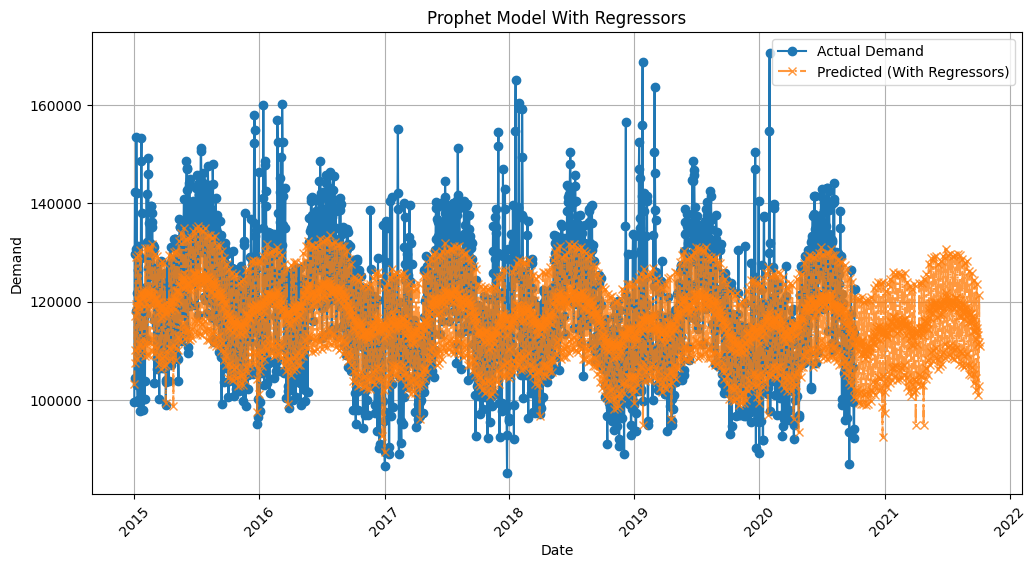

In [21]:
# Plot Prophet model WITH regressors
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted (With Regressors)", marker='x', linestyle="-.", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Prophet Model With Regressors")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get only the dates that exist in the actual dataset for evaluation
actual = df[["ds", "y"]]
predicted = forecast[["ds", "yhat"]]

# Merge actual and predicted values based on date
merged_df = actual.merge(predicted, on="ds", how="inner")

# Calculate error metrics
mae = mean_absolute_error(merged_df["y"], merged_df["yhat"])
rmse = np.sqrt(mean_squared_error(merged_df["y"], merged_df["yhat"]))
mape = np.mean(np.abs((merged_df["y"] - merged_df["yhat"]) / merged_df["y"])) * 100

# Print the results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



MAE: 8897.52
RMSE: 11625.90
MAPE: 7.15%
